In [1]:
import os

In [2]:
os.getenv("PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/chrombpnet2/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/bin:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/bin:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/bin:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/bin:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/bin:/cluster/apps/nss/jupyterhub/3.5.1/bin:/cluster/apps/gcc-8.2.0/git-2.31.1-q45wg6avfyvko4weuhmnpghaag45ynoo/bin:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/bin:/cluster/apps/gcc-8.2.0/r-4.2.2-ydfaklhfrhw5dy6qcfzxlxfviwovcord/bin:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/bin:/cluster/apps/local:/cluster/apps/sfos/bin:/usr/local/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/sbin:/bin:/cluster/slurm/

In [3]:
os.getenv("LD_LIBRARY_PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/cuda11_env/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet2/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/gcc-8.2.0/cudnn-8.9.2.26-ogi7ed2h6ejs7vumekv46idqqas4axgq/lib:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/lib64:/cluster/apps/gcc-8.2.0/nccl-2.11.4-1-pwkiz23vbeac3vt5ykybdwzaykprizb2/lib:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/lib:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64:/cluster/apps/gcc-8.2.0/zlib-1.2.9-roj3c3p7lbd2kn3gstlt4rxdcgvb3csi/lib:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/lib64:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/lib:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/lib:/cluster/apps/gcc-8.2.

In [4]:
# Adapted from chrombpnet-lite

import deepdish as dd
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import shap
import pyfaidx
import shutil
import errno
import os


In [5]:
import argparse
import chrombpnet.evaluation.interpret.shap_utils as shap_utils
import chrombpnet.evaluation.interpret.input_utils as input_utils

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]


In [6]:
# disable eager execution so shap deep explainer wont break
tf.compat.v1.disable_eager_execution()


In [7]:
def fetch_interpret_args():
    parser = argparse.ArgumentParser(description="get sequence contribution scores for the model")
    parser.add_argument("-g", "--genome", type=str, required=True, help="Genome fasta")
    parser.add_argument("-r", "--regions", type=str, required=True, help="10 column bed file of peaks. Sequences and labels will be extracted centered at start (2nd col) + summit (10th col).")
    parser.add_argument("-m", "--model_h5", type=str, required=True, help="Path to trained model, can be both bias or chrombpnet model")
    parser.add_argument("-o", "--output-prefix", type=str, required=True, help="Output prefix")
    parser.add_argument("-d", "--debug_chr", nargs="+", type=str, default=None, help="Run for specific chromosomes only (e.g. chr1 chr2) for debugging")
    parser.add_argument("-p", "--profile_or_counts", nargs="+", type=str, default=["counts", "profile"], choices=["counts", "profile"],
                        help="use either counts or profile or both for running shap")

    args = parser.parse_args()
    return args


In [8]:
def generate_shap_dict(seqs, scores):
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1)).astype(np.int8)},
            'shap': {'seq': np.transpose(scores, (0, 2, 1)).astype(np.float16)},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1)).astype(np.float16)}
        }

    return d


In [9]:
def interpret(model, seqs, output_prefix, profile_or_counts,save_files=True):
    print("Seqs dimension : {}".format(seqs.shape))

    outlen = model.output_shape[0][1]

    profile_model_input = model.input
    profile_input = seqs
    counts_model_input = model.input
    counts_input = seqs

    if "counts" in profile_or_counts:
        profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
            (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'counts' shap scores")
        counts_shap_scores = profile_model_counts_explainer.shap_values(
            counts_input, progress_message=100)

        counts_scores_dict = generate_shap_dict(seqs, counts_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'counts' scores")

            dd.io.save("{}.counts_scores.h5".format(output_prefix),
                        counts_scores_dict,
                        compression='blosc')

#            del counts_shap_scores, counts_scores_dict

    if "profile" in profile_or_counts:
        weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
        profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
            (profile_model_input, weightedsum_meannormed_logits),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'profile' shap scores")
        profile_shap_scores = profile_model_profile_explainer.shap_values(
            profile_input, progress_message=100)

        profile_scores_dict = generate_shap_dict(seqs, profile_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'profile' scores")
            dd.io.save("{}.profile_scores.h5".format(output_prefix),
                        profile_scores_dict,
                        compression='blosc')
    
    results = {}
    results['profile'] = ''
    results['counts_scores'] = ''
    results['counts_shap'] = ''
    if "profile" in profile_or_counts:
        results['profile'] = profile_scores_dict
    if "counts" in profile_or_counts:
        results['counts_scores'] = counts_scores_dict
        results['counts_shap'] = counts_shap_scores

    return(results)


In [10]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv("regions_of_interest/LCT_regions_peaks.bed", sep='\t', names=NARROWPEAK_SCHEMA)


In [11]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit
0,chr2,135850768,135851620,human_peaks_peak_46168,428,.,9.08804,45.6806,42.8412,282


In [12]:
import os
import sys
import os
import sys
import tensorflow as tf
import numpy as np
import chrombpnet.training.utils.losses as losses
from chrombpnet.training.utils.data_utils import one_hot
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model


def get_seq(peaks_df, genome, width):
    """
    Same as get_cts, but fetches sequence from a given genome.
    """
    vals = []
    peaks_used = []
    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
            vals.append(sequence)
            peaks_used.append(True)
        else:
            peaks_used.append(False)

    return one_hot.dna_to_one_hot(vals), np.array(peaks_used)



In [13]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

got the model
got the model
got the model
got the model
got the model


In [14]:
# infer input length
inputlen = model.input_shape[1] # if bias model (1 input only)
print("inferred model inputlen: ", inputlen)


inferred model inputlen:  2114


In [15]:
genome_path = 'encode_data/hg38.fa'

#region 0 contains the human chimp divergent SNCs

import pyfaidx
genome_path = 'encode_data/hg38.fa'
genome = pyfaidx.Fasta(genome_path)
width = input_len = inputlen
chrom='chr2'
start,end = 135850768,135851620
summit = 282

start_use = int(start+summit - input_len/2)+1
end_use = int(start + summit + input_len/2)

middle = int((start+end)/2)
nstart = middle-int(input_len/2)
nend = nstart + input_len

#fasta format
seq_man = genome.get_seq(chrom,start_use,end_use)

#string
seq_man2 = str(genome[chrom][(start_use-1):(end_use)])


sequence = seq_man2
vals = []
if len(sequence) == width:
    vals.append(sequence)


In [16]:
human_SNCs = pd.read_csv("extra_data/hg38_panTro6_LCT_divergent_site.tsv",sep="\t")


In [17]:
human_SNCs['d_start'] = human_SNCs['hg38_coor(1-based)']-start_use
human_SNCs['d_start_match'] = [sequence[x] for x in human_SNCs['d_start']]
human_SNCs = human_SNCs.reset_index()
human_SNCs['ID'] = 'ID_'+human_SNCs['index'].astype('str')

In [18]:
def evo_seq(sequence,position,ref,alt):
    if sequence[position]==ref:
        mod_seq = sequence[:position] + alt + sequence[position + 1:]
    else:
        print("reference does not occur at position, double check position")
        mod_seq = None
    return(mod_seq)

def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)



In [19]:
def generate_binary_combinations(num_bits):
    num_combinations = 2 ** num_bits
    format_string = f'{{:0{num_bits}b}}'
    combinations = []
    for i in range(num_combinations):
        binary_string = format_string.format(i)
        combinations.append([int(bit) for bit in binary_string])
    return combinations

# Example usage for 12 binary variables
num_variables = len(human_SNCs.index)
combinations = generate_binary_combinations(num_variables)

In [20]:
all_mutated_sequences = []
all_mutated_sequences_df = []
i = 0
ref_sequences = []

for comb in combinations:
    positions = np.where(np.array(comb) == 1)[0]
    human_SNCs_comb = human_SNCs.iloc[positions].copy()

#    if len(human_SNCs_comb.index)==0:
#        comb_sequence = sequence

    comb_sequence = sequence
    
    for SNC in human_SNCs_comb.index:
        position,ref,alt = human_SNCs_comb.loc[SNC,'d_start'],human_SNCs_comb.loc[SNC,'Hg38'],human_SNCs_comb.loc[SNC,'panTro6']

        comb_sequence = evo_seq(comb_sequence,position,ref,alt)

    
    all_mutated_sequences.append(comb_sequence)
    ref_sequences.append(sequence)
    
    concatenated_ids = "_".join(human_SNCs_comb['ID'])
    total_mutations = np.sum(comb)
    
    all_mutated_sequences_df.append(dict(sequence_id=i,ntot=total_mutations,SNC=concatenated_ids))
    i+=1

In [21]:
all_mutated_sequences_df = pd.DataFrame(all_mutated_sequences_df)
all_mutated_sequences_ohe = one_hot.dna_to_one_hot(all_mutated_sequences)
ref_sequences_ohe = one_hot.dna_to_one_hot(ref_sequences)

In [22]:
#ref_batch_preds = model.predict(ref_sequences_ohe)


In [23]:
import time

In [24]:
import random
random.seed(42)

In [25]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    ref_logcount_preds=[]
    alt_logcount_preds=[]
    ref_prob_preds=[]
    alt_prob_preds=[]

    print("predict reference sequence")
    ref_batch_preds = model.predict(ref_sequences_ohe)
    time.sleep(5)

    print("predict mutations sequence")
    alt_batch_preds = model.predict(all_mutated_sequences_ohe)
    time.sleep(5)

    ref_logcount_preds.extend(np.squeeze(ref_batch_preds[1]))
    alt_logcount_preds.extend(np.squeeze(alt_batch_preds[1]))
    
    ref_prob_preds.extend(np.squeeze(softmax(ref_batch_preds[0])))
    alt_prob_preds.extend(np.squeeze(softmax(alt_batch_preds[0])))

    ref_logcount_preds = np.array(ref_logcount_preds)
    alt_logcount_preds = np.array(alt_logcount_preds)
    ref_prob_preds = np.array(ref_prob_preds)
    alt_prob_preds = np.array(alt_prob_preds)

    from scipy.spatial.distance import jensenshannon
    
    log_counts_diff = alt_logcount_preds - ref_logcount_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)*np.sign(log_counts_diff)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])*np.sign(log_counts_diff)

    all_mutated_sequences_df[fold+'--logcount_preds'] = alt_logcount_preds
    all_mutated_sequences_df[fold+'--log_counts_diff'] = log_counts_diff
    all_mutated_sequences_df[fold+'--log_probs_diff_abs_sum'] = log_probs_diff_abs_sum
    all_mutated_sequences_df[fold+'--probs_jsd_diff'] = probs_jsd_diff

fold_0
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_1
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_2
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_3
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_4
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence


In [26]:
log_counts_diff_columns = [x for x in all_mutated_sequences_df.columns if 'log_counts_diff' in x]
log_probs_diff_abs_sum_columns = [x for x in all_mutated_sequences_df.columns if 'log_probs_diff_abs_sum' in x]
probs_jsd_diff_columns = [x for x in all_mutated_sequences_df.columns if 'probs_jsd_diff' in x]
logcount_preds_columns = [x for x in all_mutated_sequences_df.columns if 'logcount_preds' in x]

In [27]:
all_mutated_sequences_df['log_counts_diff_avg'] = all_mutated_sequences_df[log_counts_diff_columns].T.mean()
all_mutated_sequences_df['logcount_preds_avg'] = all_mutated_sequences_df[logcount_preds_columns].T.mean()

all_mutated_sequences_df['log_probs_diff_abs_sum_avg'] = all_mutated_sequences_df[log_probs_diff_abs_sum_columns].T.mean()
all_mutated_sequences_df['probs_jsd_diff_avg'] = all_mutated_sequences_df[probs_jsd_diff_columns].T.mean()

In [28]:
all_mutated_sequences_df.to_csv("SNC_LCT_study_effects_wcounts_2.tsv",sep="\t")

In [29]:
all_mutated_sequences_df

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,,4.575580,0.000000,0.000000,0.000000,4.537943,0.000000,0.000000,...,0.000000,0.000000,4.123574,0.000000,0.000000,0.000000,0.000000,4.760121,0.000000,0.000000
1,1,1,ID_5,4.533257,-0.042323,-23.442638,-0.013893,4.489097,-0.048847,-26.035683,...,-18.679300,-0.012425,4.144676,0.021102,20.634243,0.011479,-0.035544,4.724576,-17.886402,-0.010171
2,2,1,ID_4,4.532566,-0.043015,-31.702385,-0.026966,4.638884,0.100941,45.191223,...,41.347904,0.030415,4.027804,-0.095770,-68.233124,-0.036524,-0.016452,4.743670,-10.440040,-0.003584
3,3,2,ID_4_ID_5,4.492068,-0.083512,-46.924232,-0.032666,4.595917,0.057973,39.500847,...,39.014385,0.031376,4.046685,-0.076890,-67.293198,-0.037925,-0.052140,4.707980,-21.976599,-0.006696
4,4,1,ID_3,4.675583,0.100003,49.796432,0.021422,4.747725,0.209781,97.306900,...,36.802025,0.020982,4.209989,0.086414,46.415882,0.019891,0.111174,4.871294,53.549305,0.023229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,5,ID_0_ID_1_ID_2_ID_4_ID_5,4.504835,-0.070745,-57.278732,-0.037418,4.409541,-0.128403,-60.845589,...,-52.788704,-0.036266,4.187670,0.064095,46.052238,0.035246,-0.110361,4.649760,-46.048939,-0.026807
60,60,4,ID_0_ID_1_ID_2_ID_3,4.694245,0.118665,64.824921,0.028657,4.536936,-0.001008,-58.305550,...,43.279076,0.026074,4.405716,0.282142,111.426369,0.043468,0.062629,4.822750,25.540634,0.009607
61,61,5,ID_0_ID_1_ID_2_ID_3_ID_5,4.649978,0.074398,62.772980,0.030161,4.472757,-0.065186,-53.380672,...,44.372307,0.029247,4.417996,0.294422,114.847641,0.044937,0.020358,4.780479,21.232800,0.008554
62,62,5,ID_0_ID_1_ID_2_ID_3_ID_4,4.643122,0.067542,59.684959,0.035717,4.670423,0.132480,93.735100,...,70.465668,0.041741,4.257915,0.134340,58.248299,0.035058,0.030102,4.790224,44.261833,0.026498


In [30]:
import seaborn as sns

<Axes: xlabel='ntot', ylabel='probs_jsd_diff_avg'>

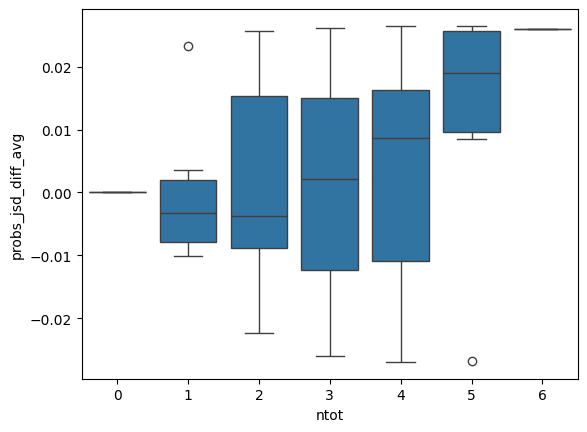

In [31]:
sns.boxplot(x='ntot',y='probs_jsd_diff_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

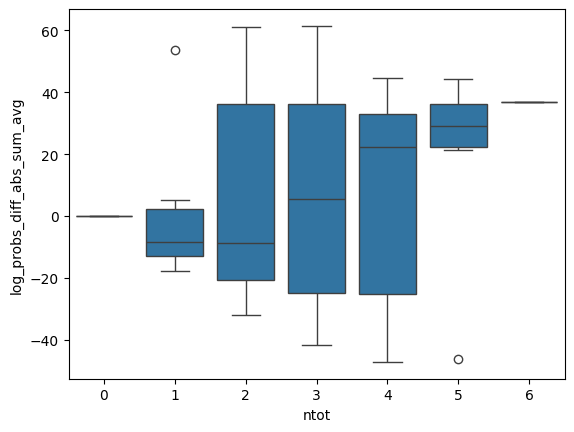

In [32]:
sns.boxplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

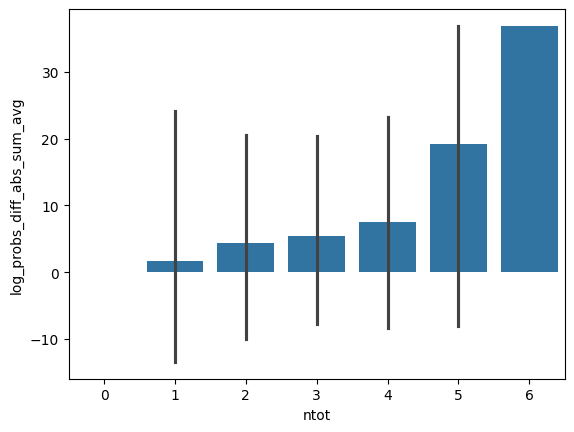

In [33]:
sns.barplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_counts_diff_avg'>

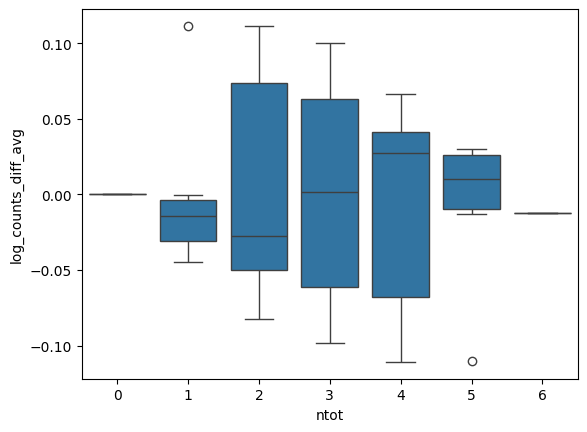

In [34]:
sns.boxplot(x='ntot',y='log_counts_diff_avg',data=all_mutated_sequences_df)

In [35]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot']==1].sort_values(by='SNC')

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
32,32,1,ID_0,4.580987,0.005407,12.003048,0.006594,4.540329,0.002385,11.277789,...,10.721183,0.005781,4.128757,0.005182,10.298062,0.007595,-0.000703,4.759418,5.111468,0.003638
16,16,1,ID_1,4.568191,-0.007389,-11.736614,-0.008277,4.525456,-0.012487,-11.791540,...,-14.780264,-0.008715,4.117899,-0.005675,-13.709848,-0.010919,-0.011564,4.748557,-13.892743,-0.009414
8,8,1,ID_2,4.593550,0.017970,20.595728,0.012801,4.346545,-0.191399,-47.476433,...,-23.976942,-0.012650,4.295385,0.171811,58.265427,0.024458,-0.044420,4.715702,-6.475136,-0.002885
4,4,1,ID_3,4.675583,0.100003,49.796432,0.021422,4.747725,0.209781,97.306900,...,36.802025,0.020982,4.209989,0.086414,46.415882,0.019891,0.111174,4.871294,53.549305,0.023229
2,2,1,ID_4,4.532566,-0.043015,-31.702385,-0.026966,4.638884,0.100941,45.191223,...,41.347904,0.030415,4.027804,-0.095770,-68.233124,-0.036524,-0.016452,4.743670,-10.440040,-0.003584
1,1,1,ID_5,4.533257,-0.042323,-23.442638,-0.013893,4.489097,-0.048847,-26.035683,...,-18.679300,-0.012425,4.144676,0.021102,20.634243,0.011479,-0.035544,4.724576,-17.886402,-0.010171


In [46]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot']==1].sort_values(by='SNC')

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
32,32,1,ID_0,4.580987,0.005407,12.003048,0.006594,4.540329,0.002385,11.277789,...,10.721183,0.005781,4.128757,0.005182,10.298062,0.007595,-0.000703,4.759418,5.111468,0.003638
16,16,1,ID_1,4.568191,-0.007389,-11.736614,-0.008277,4.525456,-0.012487,-11.791540,...,-14.780264,-0.008715,4.117899,-0.005675,-13.709848,-0.010919,-0.011564,4.748557,-13.892743,-0.009414
8,8,1,ID_2,4.593550,0.017970,20.595728,0.012801,4.346545,-0.191399,-47.476433,...,-23.976942,-0.012650,4.295385,0.171811,58.265427,0.024458,-0.044420,4.715702,-6.475136,-0.002885
4,4,1,ID_3,4.675583,0.100003,49.796432,0.021422,4.747725,0.209781,97.306900,...,36.802025,0.020982,4.209989,0.086414,46.415882,0.019891,0.111174,4.871294,53.549305,0.023229
2,2,1,ID_4,4.532566,-0.043015,-31.702385,-0.026966,4.638884,0.100941,45.191223,...,41.347904,0.030415,4.027804,-0.095770,-68.233124,-0.036524,-0.016452,4.743670,-10.440040,-0.003584
1,1,1,ID_5,4.533257,-0.042323,-23.442638,-0.013893,4.489097,-0.048847,-26.035683,...,-18.679300,-0.012425,4.144676,0.021102,20.634243,0.011479,-0.035544,4.724576,-17.886402,-0.010171


In [36]:
len(all_mutated_sequences_ohe)

64

In [37]:
len(all_mutated_sequences_ohe[0])

2114

In [38]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot'].isin([0,6])]

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,,4.575580,0.000000,0.000000,0.000000,4.537943,0.000000,0.000000,...,0.000000,0.000000,4.123574,0.00000,0.000000,0.000000,0.000000,4.760121,0.000000,0.000000
63,63,6,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5,4.596797,0.021216,62.747753,0.039782,4.612416,0.074472,85.968094,...,69.315758,0.043412,4.270564,0.14699,61.147446,0.036923,-0.012332,4.747790,36.862316,0.025951


In [39]:
all_mutated_sequences_df

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,,4.575580,0.000000,0.000000,0.000000,4.537943,0.000000,0.000000,...,0.000000,0.000000,4.123574,0.000000,0.000000,0.000000,0.000000,4.760121,0.000000,0.000000
1,1,1,ID_5,4.533257,-0.042323,-23.442638,-0.013893,4.489097,-0.048847,-26.035683,...,-18.679300,-0.012425,4.144676,0.021102,20.634243,0.011479,-0.035544,4.724576,-17.886402,-0.010171
2,2,1,ID_4,4.532566,-0.043015,-31.702385,-0.026966,4.638884,0.100941,45.191223,...,41.347904,0.030415,4.027804,-0.095770,-68.233124,-0.036524,-0.016452,4.743670,-10.440040,-0.003584
3,3,2,ID_4_ID_5,4.492068,-0.083512,-46.924232,-0.032666,4.595917,0.057973,39.500847,...,39.014385,0.031376,4.046685,-0.076890,-67.293198,-0.037925,-0.052140,4.707980,-21.976599,-0.006696
4,4,1,ID_3,4.675583,0.100003,49.796432,0.021422,4.747725,0.209781,97.306900,...,36.802025,0.020982,4.209989,0.086414,46.415882,0.019891,0.111174,4.871294,53.549305,0.023229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,5,ID_0_ID_1_ID_2_ID_4_ID_5,4.504835,-0.070745,-57.278732,-0.037418,4.409541,-0.128403,-60.845589,...,-52.788704,-0.036266,4.187670,0.064095,46.052238,0.035246,-0.110361,4.649760,-46.048939,-0.026807
60,60,4,ID_0_ID_1_ID_2_ID_3,4.694245,0.118665,64.824921,0.028657,4.536936,-0.001008,-58.305550,...,43.279076,0.026074,4.405716,0.282142,111.426369,0.043468,0.062629,4.822750,25.540634,0.009607
61,61,5,ID_0_ID_1_ID_2_ID_3_ID_5,4.649978,0.074398,62.772980,0.030161,4.472757,-0.065186,-53.380672,...,44.372307,0.029247,4.417996,0.294422,114.847641,0.044937,0.020358,4.780479,21.232800,0.008554
62,62,5,ID_0_ID_1_ID_2_ID_3_ID_4,4.643122,0.067542,59.684959,0.035717,4.670423,0.132480,93.735100,...,70.465668,0.041741,4.257915,0.134340,58.248299,0.035058,0.030102,4.790224,44.261833,0.026498


In [40]:
all_mutated_sequences_ohe_extremes = np.array([all_mutated_sequences_ohe[0],all_mutated_sequences_ohe[63]])

In [ ]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    results = interpret(model, all_mutated_sequences_ohe_extremes, 'R2_SNC_LCT_study_extr_'+fold, ['profile','counts'])

fold_0
got the model
Seqs dimension : (2, 2114, 4)

Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2


In [53]:
!mv SNC_LCT* region_scores/enterocytes/SNC_LCT_study/

Seqs dimension : (1, 2114, 4)

Generating 'counts' shap scores
Done 0 examples of 1
Generating 'profile' shap scores
Done 0 examples of 1


In [28]:
results

{'profile': {'raw': {'seq': array([[[0, 1, 1, ..., 1, 0, 0],
           [0, 0, 0, ..., 0, 0, 1],
           [1, 0, 0, ..., 0, 1, 0],
           [0, 0, 0, ..., 0, 0, 0]]], dtype=int8)},
  'shap': {'seq': array([[[-0., -0.,  0., ...,  0., -0., -0.],
           [ 0., -0., -0., ..., -0., -0.,  0.],
           [ 0.,  0.,  0., ..., -0.,  0., -0.],
           [-0.,  0.,  0., ..., -0., -0., -0.]]], dtype=float16)},
  'projected_shap': {'seq': array([[[-0., -0.,  0., ...,  0., -0., -0.],
           [ 0., -0., -0., ..., -0., -0.,  0.],
           [ 0.,  0.,  0., ..., -0.,  0., -0.],
           [-0.,  0.,  0., ..., -0., -0., -0.]]], dtype=float16)}},
 'counts_scores': {'raw': {'seq': array([[[0, 1, 1, ..., 1, 0, 0],
           [0, 0, 0, ..., 0, 0, 1],
           [1, 0, 0, ..., 0, 1, 0],
           [0, 0, 0, ..., 0, 0, 0]]], dtype=int8)},
  'shap': {'seq': array([[[ 0.,  0., -0., ...,  0., -0., -0.],
           [ 0., -0.,  0., ..., -0., -0.,  0.],
           [ 0., -0., -0., ...,  0.,  0., -0.],
  